In [1]:
# This file is modified version of original:
# https://www.kaggle.com/code/leonidkulyk/eda-mga-graphs-with-interactive-annotations

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">📊 Making Graphs Accessible 📈 - Data and problem investigation</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Use ML to create tabular data from graphs</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">(ಠಿ⁠_⁠ಠ) Overview</center>

<p style="font-family: consolas; font-size: 16px;">⚪ The goal of the competition is <b>to develop an automatic solution that can extract data represented by four types of charts commonly found in STEM textbooks</b>. This will help make reading graphs accessible to millions of students with learning differences or disabilities.
</p>

<p style="font-family: consolas; font-size: 16px;">⚪ The current process of making educational materials accessible is expensive, time-consuming, and often not available to schools or teachers without the funding to license them.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ The best submissions will be adopted into <b>Benetech's PageAI product</b>, which converts books and other educational materials into accessible formats.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ The competition is hosted by Benetech, a nonprofit organization dedicated to reducing social and economic inequality through software for social good.</p>

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">

* [Install & Import & Define](#iid)
* [1. Data overview](#1)
    * [1.1 Annotations](#1.1)
    * [1.2 Images](#1.2)
* [2. Bar chart](#2)
    * [2.1 Vertical Bar](#2.1)
    * [2.2 Horisontal Bar](#2.2)
* [3. Histogram](#3)
* [4. Dot](#4)
    * [4.1 Categorical X-Axis](#4.1)
    * [4.2 Numeric X-Axis](#4.2)
* [5. Line](#5)
* [6. Scatter](#6)
* [7. Sample Submission](#7)
    * [7.1 Sigmoid transformation](#7.1)
    * [7.2 The Evaluation Metric](#7.2)
    * [7.3 Evaluation example on test images](#7.3)

</div>

<a id="iid"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b>Install & Import & Define</b></div>

## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b>Import dependencies</b></div>

In [2]:
import os
import json
from PIL import Image
from typing import Dict

import random
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from rapidfuzz.distance.Levenshtein import distance as levenshtein

## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b>Define config</b></div>

In [3]:
class CFG:
    train_img_path: str = "/kaggle/input/benetech-making-graphs-accessible/train/images"
    train_ann_path: str = "/kaggle/input/benetech-making-graphs-accessible/train/annotations"
        
    test_img_path: str = "/kaggle/input/benetech-making-graphs-accessible/test/images"

## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b>Define utilization methods</b></div>

In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
def get_annotations():
    annotations_path = "/kaggle/input/benetech-making-graphs-accessible/train/annotations"
    
    annotations = []
    for annotation_path in os.listdir(CFG.train_ann_path):
        with open(f"{CFG.train_ann_path}/{annotation_path}") as annotation_f:
            annotations.append(json.load(annotation_f))
    return annotations

In [6]:
def get_chart_type_counts(annotations):
    chart_type_counts = {
        "dot": 0,
        "line": 0,
        "scatter": 0,
        "vertical_bar": 0,
        "horizontal_bar": 0
    }
    
    for annotation in annotations:
        chart_type_counts[annotation["chart-type"]] += 1
            
    return chart_type_counts

In [7]:
def load_annotation(name: str) -> Dict:
    with open(f"{CFG.train_ann_path}/{name}.json") as annotation_f:
        ann_example = json.load(annotation_f)
    return ann_example

In [8]:
def get_coords(polygon, img_height):
    xs = [
        polygon["x0"], 
        polygon["x1"], 
        polygon["x2"], 
        polygon["x3"], 
        polygon["x0"]
    ]
    
    ys = [
        -polygon["y0"] + img_height, 
        -polygon["y1"] + img_height, 
        -polygon["y2"] + img_height, 
        -polygon["y3"] + img_height, 
        -polygon["y0"] + img_height
    ]
    
    return xs, ys

In [9]:
def add_line_breaks(text: str, break_num: int = 7) -> str:
    words = text.split()
    new_text = ""
    for i, word in enumerate(words, start=1):
        new_text += word
        if i % break_num == 0:
            new_text += "<br>"
        else:
            new_text += " "
    return new_text

In [10]:
def get_tick_value(name, data_series):
    for el in data_series:
        if el["x"] == name:
            return el["y"]
        elif el["y"] == name:
            return el["x"]

In [11]:
def plot_annotated_image(name: str, scale_factor: int = 1.0) -> None:
    img_example = Image.open(f"{CFG.train_img_path}/{name}.jpg")
    ann_example = load_annotation(name)
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add bounding box
    fig.add_shape(
        type="rect",
        x0=ann_example["plot-bb"]["x0"], 
        y0=-ann_example["plot-bb"]["y0"] + img_height, 
        x1=ann_example["plot-bb"]["x0"] + ann_example["plot-bb"]["width"], 
        y1=-(ann_example["plot-bb"]["y0"] + ann_example["plot-bb"]["height"]) + img_height,
        line=dict(color="RoyalBlue"),
    )
    
    # add polygons
    for text in ann_example["text"]:
        name = text["text"]
        
        if text["role"] == "tick_label":
            tick_value = get_tick_value(name, ann_example["data-series"])
            if tick_value:
                name = f'Text: {name}<br>Value: {tick_value}'
        
        xs, ys = get_coords(text["polygon"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=add_line_breaks(name),
            hovertemplate="%{name}",
            mode='lines'
        ))
    
    # add x-axis dots
    xs = [dot["tick_pt"]["x"] for dot in ann_example["axes"]["x-axis"]["ticks"]]
    ys = [-dot["tick_pt"]["y"] + img_height for dot in ann_example["axes"]["x-axis"]["ticks"]]
    fig.add_trace(go.Scatter(
        x=xs, y=ys, mode='markers',
        name="x-axis"
    ))
    
    # add y-axis dots
    xs = [dot["tick_pt"]["x"] for dot in ann_example["axes"]["y-axis"]["ticks"]]
    ys = [-dot["tick_pt"]["y"] + img_height for dot in ann_example["axes"]["y-axis"]["ticks"]]
    fig.add_trace(go.Scatter(
        x=xs, y=ys, mode='markers',
        name="y-axis"
    ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Data overview</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ This competition's dataset comprises about <b>65,000</b> comprehensively-annotated scientific figures of four kinds:</p> 

* <p style="font-family: consolas; font-size: 16px;"><code>bar graphs</code></p> 
* <p style="font-family: consolas; font-size: 16px;"><code>dot plots</code></p> 
* <p style="font-family: consolas; font-size: 16px;"><code>line graphs</code></p> 
* <p style="font-family: consolas; font-size: 16px;"><code>scatter plots</code></p> 

<p style="font-family: consolas; font-size: 16px;">⚪ While the majority of the figures are synthetic, also included several thousand figures extracted from professionally-produced sources. Our task is to predict the data series depicted in the test set figures.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Images and annotations with the same name are a pair. That is, the number of images and the number of annotations are exactly the same and they all have exactly the same names except for the format (images in <code>.jpg</code> and annotations in <code>.json</code> format).</p>

<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.1 Annotations</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Collection of JSON image annotations describing the figures:</p> 

* <p style="font-family: consolas; font-size: 16px;"><code>source</code> Whether <code>generated</code> or <code>extracted</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>chart-type</code> One of <code>dot</code>, <code>horizontal_bar</code>, <code>vertical_bar</code>, <code>line</code>, <code>scatter</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>plot-bb</code> Bounding box of the plot within the figure, given by <code>height</code>, <code>width</code>, <code>x0</code>, and <code>y0</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>text/id</code> Identifier for a text item within the figure.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>text/polygon</code> Region bounding the text item in the image.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>text/text</code> The text itself.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>text/role </code> The function of the text in the image, whether <code>chart_title</code>, <code>axis_title</code>, <code>tick_label</code>, etc.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>axes/{x|y}-axis/ticks/id</code> Identifier matching the tick to the associated text element <code>id</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>axes/{x|y}-axis/ticks/tick_pt</code> Coordinates of each tick in the figure.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>axes/{x|y}-axis/tick-type</code> The graphical depiction of the tick element.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>axes/{x|y}-axis/values-type</code> The data type of the values represented by the tick element, whether <code>categorical</code> or <code>numerical</code>. This field determines how the predicted data series are scored. See the Evaluation page for more information.</p> 
* <p style="font-family: consolas; font-size: 16px;"><code>data-series/{x|y}</code> The x and y coordinates of values depicted in the figure. For the test set images, this is the target to be predicted.</p> 

In [12]:
annotations = get_annotations()

<p style="font-family: consolas; font-size: 16px;">⚪ Here's an annotation example:</p> 

In [13]:
annotation_example = load_annotation("0000ae6cbdb1")

# remove some data to make output it more readable
annotation_example["text"] = [annotation_example["text"][0]]
annotation_example["axes"]["x-axis"]["ticks"] = [annotation_example["axes"]["x-axis"]["ticks"][0]]
annotation_example["axes"]["y-axis"]["ticks"] = [annotation_example["axes"]["y-axis"]["ticks"][0]]
annotation_example["data-series"] = [annotation_example["data-series"][0]]

print(json.dumps(annotation_example, indent=2))

{
  "source": "generated",
  "chart-type": "vertical_bar",
  "plot-bb": {
    "height": 137,
    "width": 379,
    "x0": 83,
    "y0": 53
  },
  "text": [
    {
      "id": 0,
      "polygon": {
        "x0": 53,
        "x1": 412,
        "x2": 412,
        "x3": 53,
        "y0": 7,
        "y1": 7,
        "y2": 30,
        "y3": 30
      },
      "text": "Estimates, 1950-2020: Total population by board age group, both sexes combined (thousands)-Population under age 15-64 for the year 1960",
      "role": "chart_title"
    }
  ],
  "axes": {
    "x-axis": {
      "ticks": [
        {
          "id": 10,
          "tick_pt": {
            "x": 103,
            "y": 190
          }
        }
      ],
      "tick-type": "markers",
      "values-type": "categorical"
    },
    "y-axis": {
      "ticks": [
        {
          "id": 3,
          "tick_pt": {
            "x": 83,
            "y": 53
          }
        }
      ],
      "tick-type": "markers",
      "values-type": "numerica

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot pie distribution of chart-type.</p> 

In [14]:
chart_type_counts = get_chart_type_counts(annotations)

fig = px.pie(values=chart_type_counts.values(), names=chart_type_counts.keys())
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of chart-type label",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">⚪ As you can see, there're only 73 train examples for the <code>horizontal_bar</code>.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ It is important to note that all coordinates in the annotation are in screen coordinates. Keep this in mind, if it is more convenient for you to work in Cartesian coordinates. Screen coordinates example:</p>

<p style="text-align:center;"><img src="https://qph.cf2.quoracdn.net/main-qimg-8cb9cec0847feb56e66a25d686852887" width="90%" height="90%"></p>

<a id="1.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.2 Images</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Train images can be found at <b>train/images/</b>. This is a collection of figures in JPG format to be used as training data.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Test images can be found at <b>test/images/</b>. This is a collection of figures to be used as test data. Our task is to predict each corresponding data series for the figures in this folder. The public version of this folder contains only a few example images drawn from the training set.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Here's an image example:</p> 

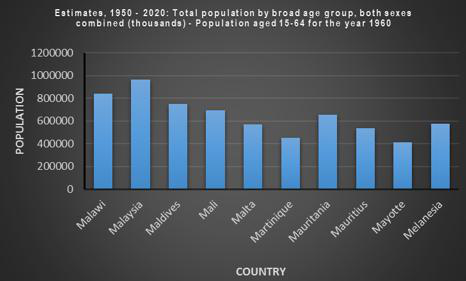

In [15]:
Image.open("/kaggle/input/benetech-making-graphs-accessible/train/images/0000ae6cbdb1.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Next I'll consider how to determine which values to predict for each figure type. These conventions ensure that predictions can be made in a consistent manner across a variety of chart formats. Be sure to review them carefully.</p> 

<p style="font-family: consolas; font-size: 16px;">As a rule:</p> 

* <p style="font-family: consolas; font-size: 16px;">Categorical values always correspond to a tick label on an axis.</p> 
* <p style="font-family: consolas; font-size: 16px;">Numerical values must be inferred from the tick labels through interpolation.</p> 

<p style="font-family: consolas; font-size: 16px;">🔴 Now let's consider each of the four types of charts.</p> 

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Bar chart</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The dataset contains both vertical bar charts and horizontal bar charts. Vertical bar charts have their independent values along the x-axis and their dependent values along the y-axis, while horizontal bar charts have the roles of the axes switched. Independent values will always be categorical and can be identified as the series of tick-labels below each bar. Dependent values will always be numeric and are identified by the height (or length) of the bar.</p>

<a id="2.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.1 Vertical Bar</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [16]:
vb_example_name = "0000ae6cbdb1"

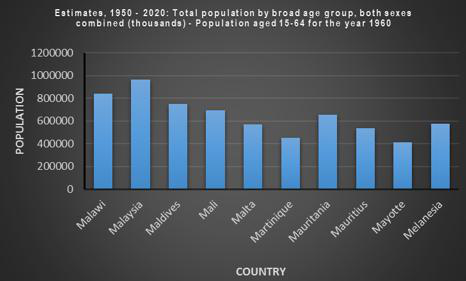

In [17]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{vb_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


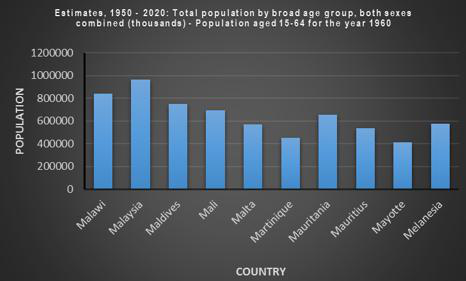

In [18]:
plot_annotated_image(vb_example_name, scale_factor=1.5)

<p style="font-family: consolas; font-size: 16px;">⚪ Each element on the x-axis corresponds to the height value of the bar. You can verify this by hovering over any of the elements.</p>

<a id="2.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.2 Horizontal Bar</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [19]:
hb_example_name = "8b6935f7ef04"

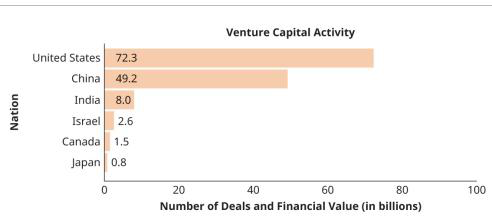

In [20]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{hb_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


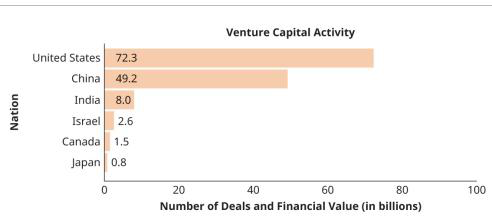

In [21]:
plot_annotated_image(hb_example_name, scale_factor=1.5)

<p style="font-family: consolas; font-size: 16px;">⚪ Now it's vice versa. Each element on the y-axis corresponds to the width value of the bar.</p>

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. Histogram</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Bar charts may also appear as <b>histograms</b>. In this case, the x labels occur at the ends of each bar and the x data series will have one more value than the y data series. Histograms are always of the vertical type.</p>

<p style="text-align:center;"><img src="https://user-images.githubusercontent.com/45982614/227718960-45a33d47-4a84-4249-8d3a-d1c098c27334.png" width="70%" height="70%"></p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks. I didn't find any histogram examles manually, so bellow just approximation of it.</p>

In [22]:
h_example_name = "00cee4e08d80"

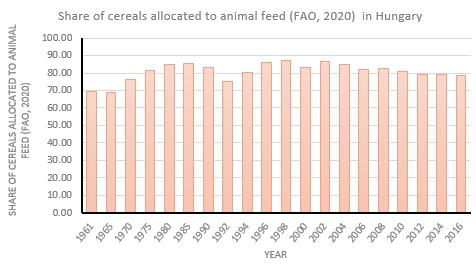

In [23]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{h_example_name}.jpg")


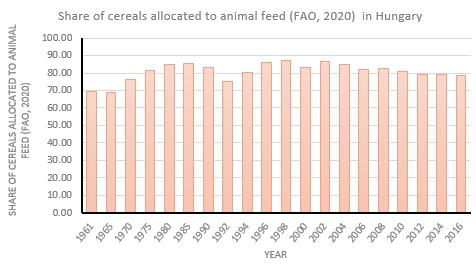

In [24]:
plot_annotated_image(h_example_name, scale_factor=1.5)

<p style="font-family: consolas; font-size: 16px;">⚪ It's pretty similar to vertical bars but with x-axis shift.</p>

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. Dot</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Dot plots have their independent values along the x-axis and their dependent values on the y-axis. The x-axis values will be numeric if the tick labels can be parsed as Python floats; otherwise, they are categorical. The y-axis values are the number of dots in each column. The y-axis itself may or may not be present in the figure.</p>

<a id="4.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 4.1 Categorical X-Axis</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [25]:
cd_example_name = "000917f5d829"

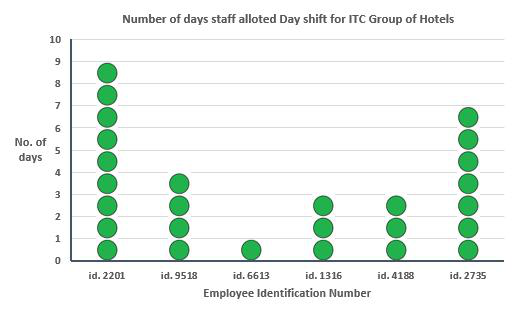

In [26]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{cd_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


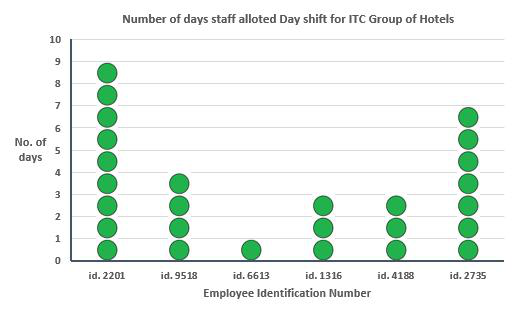

In [27]:
plot_annotated_image(cd_example_name, scale_factor=1.3)

<a id="4.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 4.2 Numeric X-Axis</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [28]:
nd_example_name = "000944919c5c"

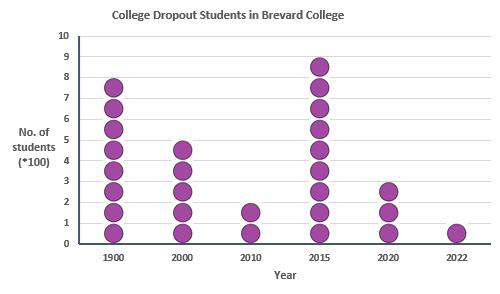

In [29]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{nd_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


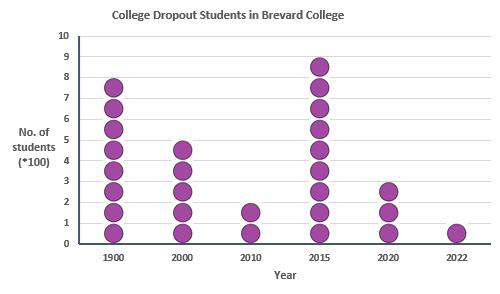

In [30]:
plot_annotated_image(nd_example_name, scale_factor=1.3)

<p style="font-family: consolas; font-size: 16px;">⚪ Some of elements overlapped. So to hover you need to scale plot first.</p>

<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 5. Line</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Line graphs always have categorical x-axis values and numeric y-axis values. The values for the x-axis are the x-axis tick labels beneath some portion of the line graph. Tick labels not beneath some portion of the graph are not included in the series. The values for the y-axis are the corresponding dependent values indicated by the graph.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [31]:
l_example_name = "0005413054c9"

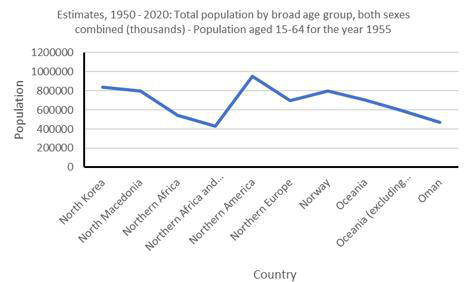

In [32]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{l_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


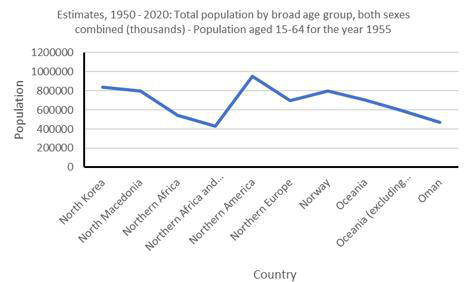

In [33]:
plot_annotated_image(l_example_name, scale_factor=1.3)

<a id="6"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 6. Scatter</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Scatter plots always have numeric x-axis values and numeric y-axis values. You should predict both x and y values for each point present in the figure. There may be multiple points with the same x- or y-coordinate.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's plot an image to see how it looks.</p>

In [34]:
s_example_name = "0005e64fdc6e"

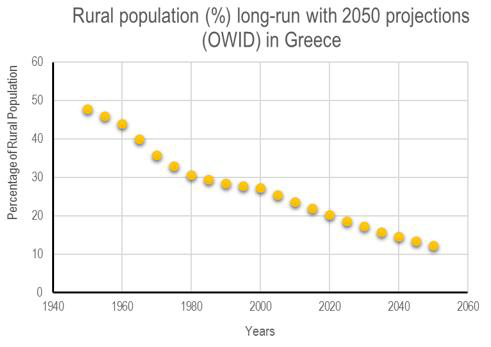

In [35]:
Image.open(f"/kaggle/input/benetech-making-graphs-accessible/train/images/{s_example_name}.jpg")

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's add annotations to the image.</p>


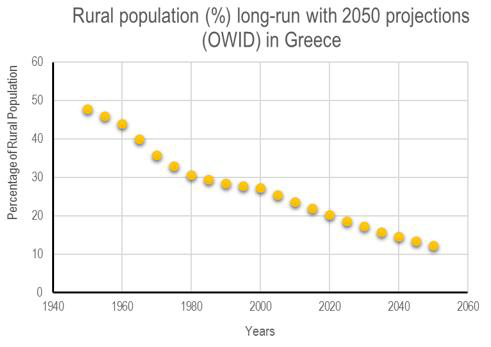

In [36]:
plot_annotated_image(s_example_name, scale_factor=1.3)

<p style="font-family: consolas; font-size: 16px;">⚪ The interesting thing is that each point on the graph has its own label. But the markup scale is not the scale of the image, but is the scale of the graph itself.</p>

In [37]:
load_annotation(s_example_name)["data-series"]

[{'x': 1949.161409571262, 'y': 48.03480783176216},
 {'x': 1954.1760758629002, 'y': 45.946337926033365},
 {'x': 1958.9978703740908, 'y': 44.20594633792606},
 {'x': 1964.2054084461768, 'y': 39.85496736765774},
 {'x': 1969.220074737815, 'y': 35.503988397389435},
 {'x': 1974.234741029453, 'y': 32.719361856417706},
 {'x': 1979.442279101539, 'y': 30.456852791878188},
 {'x': 1984.2640736127296, 'y': 29.412617839013794},
 {'x': 1989.2787399043677, 'y': 28.54242204496013},
 {'x': 1994.293406196006, 'y': 28.020304568527933},
 {'x': 1999.6938160485395, 'y': 27.672226250906473},
 {'x': 2004.51561055973, 'y': 25.409717186366947},
 {'x': 2009.3374050709206, 'y': 23.669325598259626},
 {'x': 2013.9663278016635, 'y': 21.928934010152304},
 {'x': 2019.1738658737493, 'y': 20.014503263234246},
 {'x': 2024.1885321653876, 'y': 18.448150833937657},
 {'x': 2029.3960702374734, 'y': 17.577955039883992},
 {'x': 2034.4107365291115, 'y': 15.663524292965942},
 {'x': 2039.0396592598545, 'y': 14.44525018129081},
 {'x'

<p style="font-family: consolas; font-size: 16px;">⚪ That is, the points have real coordinates, which complicates the task of their visualization. Since we know the value of the start and end points on the graph and the graph bounding box itself, we can rescale all the points under the image scale. I will do it in the next versions of the notebook.</p>

<a id="7"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 7. Sample Submission</b></div>

<p style="font-family: consolas; font-size: 16px;">🔴 The objective of the competition is to predict the data series represented by four kinds of scientific figures (or charts).</p>

<a id="7.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.1 Sigmoid transformation</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The data series for a single figure comprises two instances for evaluation: the series of values along the x-axis and the corresponding series of values along the y-axis. Each data series will be either of numerical type or of categorical type as determined by the type of chart.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Predicted data series are evaluated by a combination of two metrics, <a href="https://en.wikipedia.org/wiki/Levenshtein_distance"><strong>Levenshtein distance</strong></a> for categorical (that is, string) data types and <a href="https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/"><strong>RMSE</strong></a> for numerical data types, with an initial <b>exact-match</b> criterion for the chart type and the number of values in the series. Each of these distances is rescaled and mapped to a common similarity scale by a <b>sigmoid-type transform</b> with an optimum value of <code>1</code>:</p>

<p style="text-align:center;"><img src="https://user-images.githubusercontent.com/45982614/227719810-0a01a522-cffa-4217-90a1-c2508af7b504.png" width="25%" height="25%"></p>



In [38]:
def sigmoid(x):
    return 2 - (2 / (1 + np.exp(-x)))

x = np.linspace(0, 10, 1000)

fig = px.line(x=x, y=sigmoid(x))
fig.update_layout(
    title={
        'text': "Sigmoid transformation mapping plot",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(l=0, r=0, t=35, b=0)
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">🔴 This type of sigmoid transformation maps distances on [0,∞) to (0,1] with value of 1 at 0 and a derivative -1 at 0. The intent is to transform the different scales of the RMSE and Levenshtein distances to a common "similarity" scale with the optimum value of 1. The intent of sigmoid transformation is to transform the different scales of the RMSE and Levenshtein distances to a common "similarity" scale with the optimum value of 1.</p>

<a id="7.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.2 The Evaluation Metric</b></div>

<p style="font-family: consolas; font-size: 16px;">🔴 Evaluation of a single instance proceeds as follows:</p>

* <p style="font-family: consolas; font-size: 16px;"> 1. First check the number of values and type of chart predicted for a series. If either of these is different than that in the ground-truth, the score for that series is 0. Otherwise, we evaluate the predicted series by the data type of that series as given in the field <code>axes/{x|y}-axis/values-type</code>.</p>

* <p style="font-family: consolas; font-size: 16px;"> 2. a) For series of numerical type, we evaluate predictions by a <b>normalized RMSE</b>:</p>

<p style="text-align:center;"><img src="https://user-images.githubusercontent.com/45982614/227719813-a06f80e7-284e-4f11-b12a-ae280c628d4b.png" width="30%" height="30%"></p>

<p style="font-family: consolas; font-size: 16px;">⚪ Note that the argument to the sigmoid transform is equal to one minus the R2 score.</p>

In [39]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def normalized_rmse(y_true, y_pred):
    return sigmoid(rmse(y_true, y_pred) / rmse(y_true, np.mean(y_true)))

* <p style="font-family: consolas; font-size: 16px;"> 2. b) For series of categorical type, we evaluate predictions by a <b>normalized Levenshtein distance</b>:</p>

<p style="text-align:center;"><img src="https://user-images.githubusercontent.com/45982614/227719817-e8df71fa-2197-43ff-a39a-351b45fce4fb.png" width="30%" height="30%"></p>

<p style="font-family: consolas; font-size: 16px;">⚪ In other words, NLev is the sum of the Levenshtein distances for each category string divided by the total length of all strings for that instance.</p>

In [40]:
def normalized_levenshtein_score(y_true, y_pred):
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)

<p style="font-family: consolas; font-size: 16px;">🔴 The <b>overall score</b> is the mean of the similarity scores over all instances.</p>

In [41]:
def score_series(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        return normalized_rmse(y_true, y_pred)


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.
    
    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series` 
        should be either arrays of floats or arrays of strings.
    
    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError("Must have exactly one prediction for each ground-truth instance.")
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(ground_truth.itertuples(index=False), predictions.itertuples(index=False))
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        if gt_type != pred_type:  # Check chart_type condition
            scores.append(0.0)
        else:  # Score with RMSE or Levenshtein as appropriate
            scores.append(score_series(gt_series, pred_series))
    return np.mean(scores)

<a id="7.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.3 Evaluation example on test images</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's get 2 examples from the test images:</p>

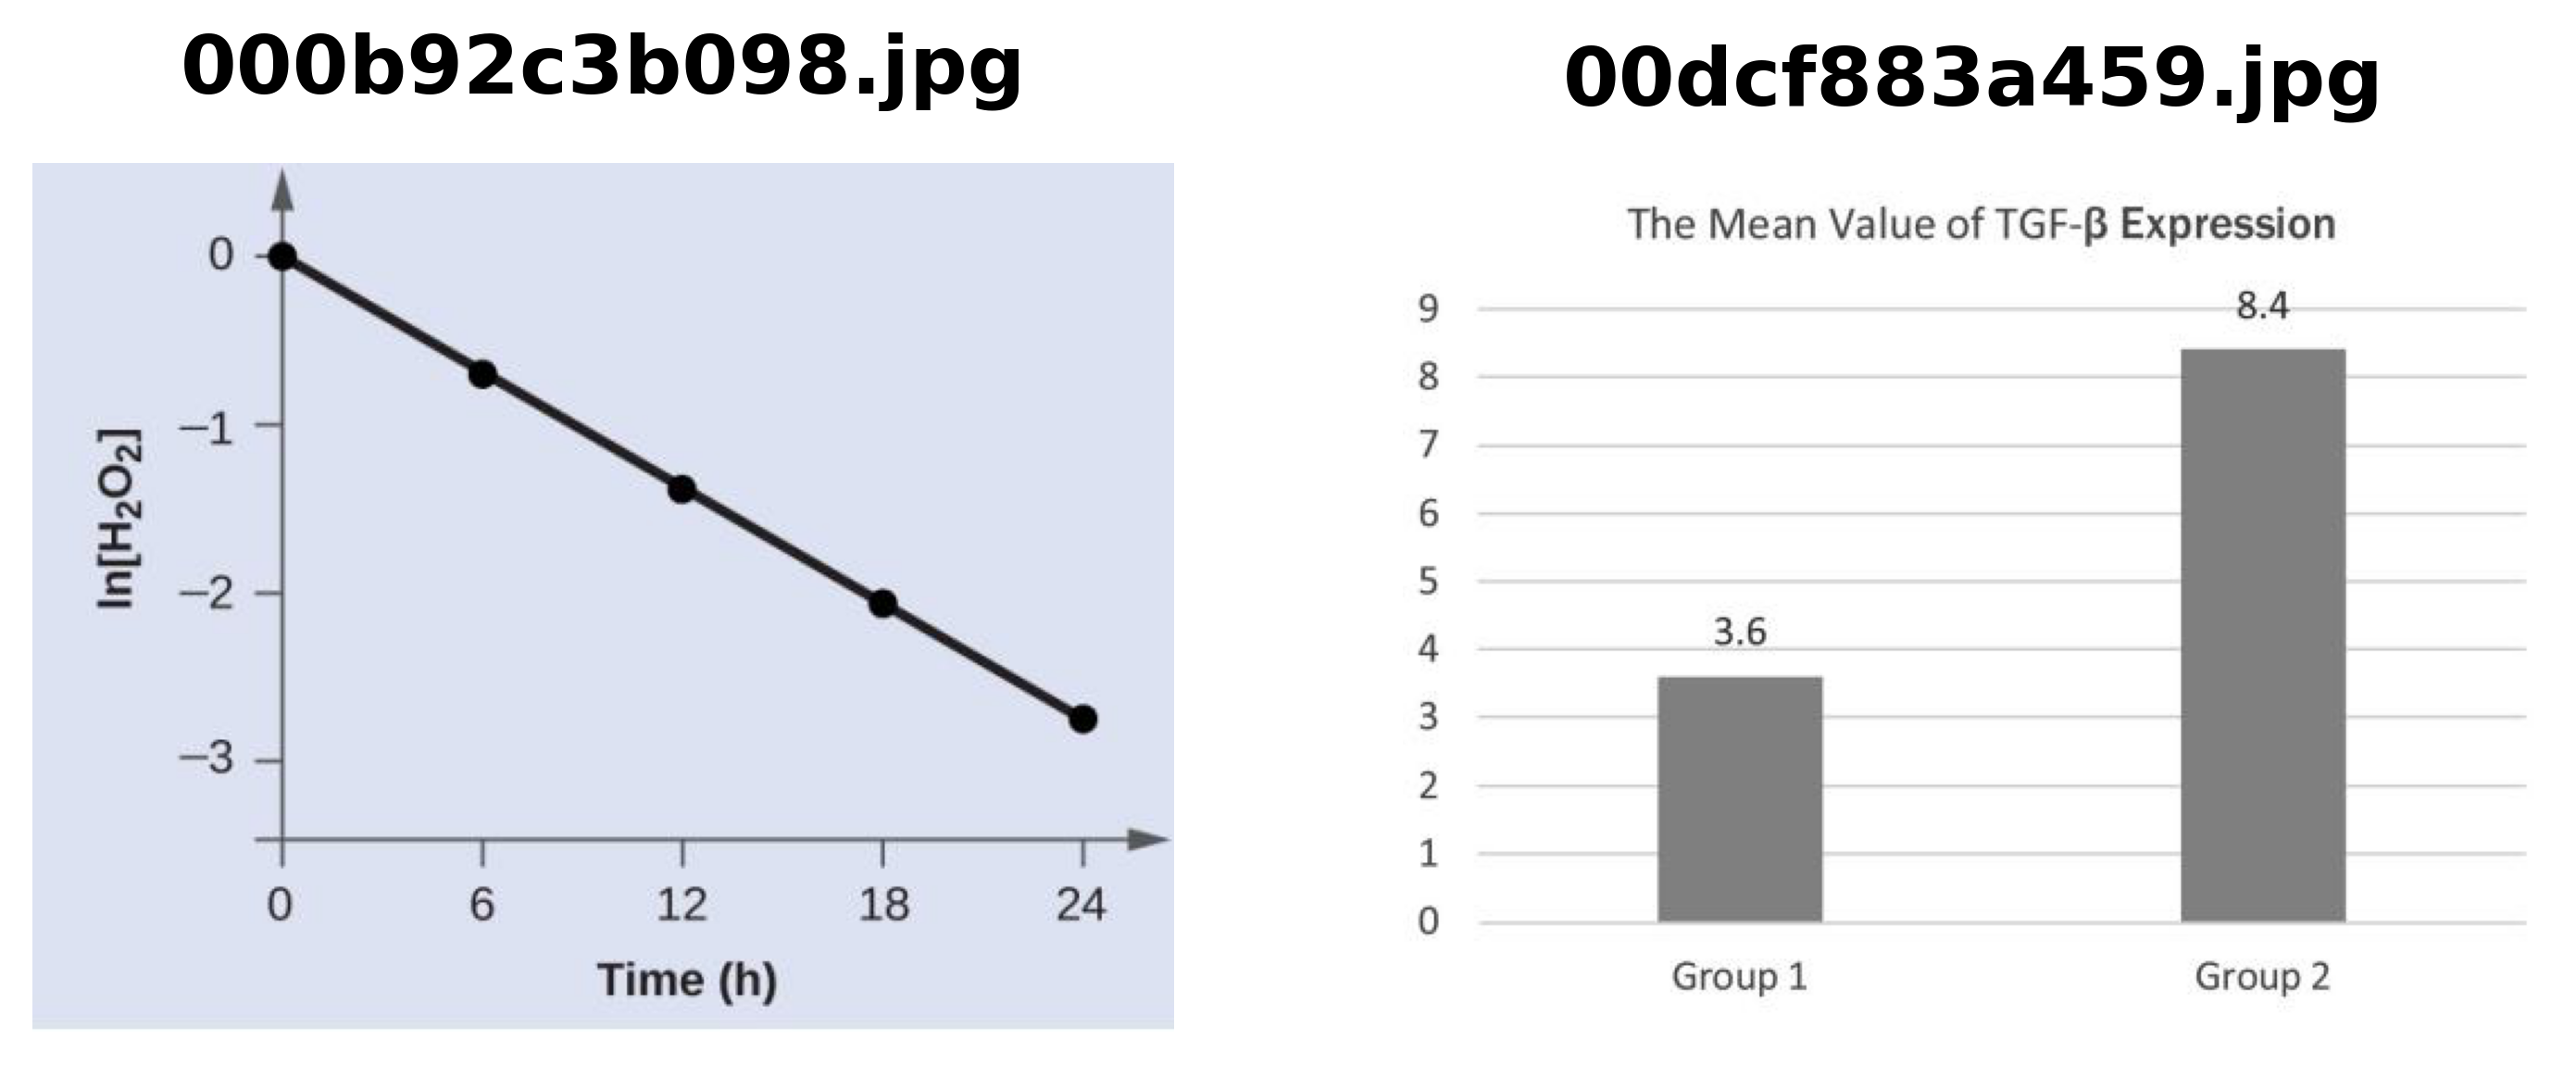

In [42]:
test_img_1 = "000b92c3b098.jpg"
test_img_2 = "00dcf883a459.jpg"
fig, axs = plt.subplots(1, 2, figsize=(10, 30), dpi=350)

axs[0].axis('off')
axs[0].text(
    0.5, 1.08, test_img_1, fontweight='bold', fontsize=18,
    transform=axs[0].transAxes, horizontalalignment='center'
)
axs[0].imshow(Image.open(f"{CFG.test_img_path}/{test_img_1}"), cmap='gray')

axs[1].axis('off')
axs[1].text(
    0.5, 1.08, test_img_2, fontweight='bold', fontsize=18,
    transform=axs[1].transAxes, horizontalalignment='center'
)
axs[1].imshow(Image.open(f"{CFG.test_img_path}/{test_img_2}"), cmap='gray');

<p style="font-family: consolas; font-size: 16px;">⚪ Write ground truth for them:</p>

In [43]:
ground_truth = pd.DataFrame.from_dict({
    '000b92c3b098_x': ([0, 6, 12, 18, 24], 'line'),
    '000b92c3b098_y': ([0, -0.8, -1.5, -2.1, -2.8], 'line'),
    
    '00dcf883a459_x': (["Group 1", "Group 2"], 'vertical_bar'),
    '00dcf883a459_y': ([3.6, 8.4], 'vertical_bar'),
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

ground_truth

,data_series,chart_type
id,,
000b92c3b098_x,"[0, 6, 12, 18, 24]",line
000b92c3b098_y,"[0, -0.8, -1.5, -2.1, -2.8]",line
00dcf883a459_x,"[Group 1, Group 2]",vertical_bar
00dcf883a459_y,"[3.6, 8.4]",vertical_bar


<p style="font-family: consolas; font-size: 16px;">⚪ And imagine what predictions would look like:</p>

In [44]:
predictions = pd.DataFrame.from_dict({
    '000b92c3b098_x': ([0, 6, 12, 18, 24], 'line'),
    '000b92c3b098_y': ([0, -0.9, -1.6, -2.2, -2.9], 'line'),
    
    '00dcf883a459_x': (["Group 1", "Group 2"], 'vertical_bar'),
    '00dcf883a459_y': ([3.0, 8.8], 'vertical_bar'),
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

predictions

,data_series,chart_type
id,,
000b92c3b098_x,"[0, 6, 12, 18, 24]",line
000b92c3b098_y,"[0, -0.9, -1.6, -2.2, -2.9]",line
00dcf883a459_x,"[Group 1, Group 2]",vertical_bar
00dcf883a459_y,"[3.0, 8.8]",vertical_bar


<p style="font-family: consolas; font-size: 16px;">⚪ Now we can obtain Benetech score for the test images:</p>

In [45]:
test_score = benetech_score(ground_truth, predictions)

print(f"Test Benetech Score: {color.BOLD}{color.CYAN}{test_score}{color.END}")

Test Benetech Score: 0.9621057281170396


<p style="font-family: consolas; font-size: 16px;">🔴 Of course during inference you must save this dataframe in <code>.csv</code> format.</p>

In [46]:
predictions.to_csv("sample_submission.csv")

In [47]:
# (⁠ ⁠ꈍ⁠ᴗ⁠ꈍ⁠) WORK STILL IN PROGRESS

# <div style="box-shadow: rgba(240, 46, 170, 0.4) -5px 5px inset, rgba(240, 46, 170, 0.3) -10px 10px inset, rgba(240, 46, 170, 0.2) -15px 15px inset, rgba(240, 46, 170, 0.1) -20px 20px inset, rgba(240, 46, 170, 0.05) -25px 25px inset; padding:20px; font-size:30px; font-family: consolas; display:fill; border-radius:15px; color: rgba(240, 46, 170, 0.7)"> <b> ༼⁠ ⁠つ⁠ ⁠◕⁠‿⁠◕⁠ ⁠༽⁠つ Thank You!</b></div>

<p style="font-family:verdana; color:rgb(34, 34, 34); font-family: consolas; font-size: 16px;"> 💌 Thank you for taking the time to read through my notebook. I hope you found it interesting and informative. If you have any feedback or suggestions for improvement, please don't hesitate to let me know in the comments. <br><br> 🚀 If you liked this notebook, please consider upvoting it so that others can discover it too. Your support means a lot to me, and it helps to motivate me to create more content in the future. <br><br> ❤️ Once again, thank you for your support, and I hope to see you again soon!</p>